### Import relevant libraries

In [1]:
import pathlib
import os
import datetime

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# %load_ext tensorboard

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import L2

from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
import prd_pipeline

In [7]:
import mlflow
mlflow.tensorflow.autolog()

### Load data

In [8]:
data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis') / 'storm_dennis_6hr_lt'

In [9]:
filename = 'prd_merged_20200214T1800Z_20200217T1200Z.csv'
data = pd.read_csv(
    data_dir / filename,
    index_col=0)

In [10]:
data

,latitude,longitude,time,radar_max_rain_aggregate_3hr,radar_mean_rain_aggregate_3hr,radar_mean_rain_instant,radar_max_rain_instant,radar_fraction_in_band_aggregate_3hr_0.00,radar_fraction_in_band_aggregate_3hr_0.03,radar_fraction_in_band_aggregate_3hr_0.09,...,wind_speed_2750.0,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0
0,49.21875,-5.765625,2020-02-14 18:00:00,0.502604,0.333577,0.050672,1.28125,0.0,0.0,0.0,...,22.3125,22.6875,23.5000,25.0000,27.1250,29.7500,31.6250,33.1250,32.9375,32.1250
1,49.21875,-5.765625,2020-02-14 18:00:00,0.502604,0.333577,0.050672,1.28125,0.0,0.0,0.0,...,22.6250,22.4375,22.3125,22.6250,23.8125,26.0625,29.6875,31.6250,32.7500,31.8750
2,49.21875,-5.765625,2020-02-14 18:00:00,0.502604,0.333577,0.050672,1.28125,0.0,0.0,0.0,...,22.9375,23.3125,24.0625,25.8125,27.9375,29.6250,30.3125,32.9375,33.6250,33.3750
3,49.21875,-5.765625,2020-02-14 18:00:00,0.502604,0.333577,0.050672,1.28125,0.0,0.0,0.0,...,22.9375,23.3125,23.5625,24.2500,25.7500,28.2500,30.3750,30.8750,31.0625,31.0625
4,49.21875,-5.765625,2020-02-14 18:00:00,0.502604,0.333577,0.050672,1.28125,0.0,0.0,0.0,...,22.0000,22.1875,23.2500,25.2500,27.3750,28.9375,30.9375,32.8750,32.5625,32.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267727,57.28125,-4.359375,2020-02-17 12:00:00,0.000000,0.000000,0.000000,0.00000,1.0,0.0,0.0,...,27.8750,28.3125,28.7500,29.2500,29.9375,30.8125,32.8125,33.1875,31.7500,29.8750
267728,57.28125,-4.359375,2020-02-17 12:00:00,0.000000,0.000000,0.000000,0.00000,1.0,0.0,0.0,...,28.0000,28.2500,28.2500,28.3125,28.6875,29.3750,31.9375,34.1875,34.3125,33.8125
267729,57.28125,-4.359375,2020-02-17 12:00:00,0.000000,0.000000,0.000000,0.00000,1.0,0.0,0.0,...,26.3125,26.7500,27.0625,27.3750,27.8125,28.4375,30.5000,32.1250,33.6250,35.3125
267730,57.28125,-4.359375,2020-02-17 12:00:00,0.000000,0.000000,0.000000,0.00000,1.0,0.0,0.0,...,29.7500,29.8125,29.8750,30.2500,31.0000,32.0000,33.4375,33.3125,33.8125,35.1875


In [11]:
new_bands = {
    'fraction_in_band_0.0_0.5': ['0.00', '0.03', '0.09', '0.10', '0.25', '0.30'], 
    'fraction_in_band_0.5_4': ['0.50', '1.00', '2.00', '3.00'], 
    'fraction_in_band_4_12': [ '4.00', '8.00'], 
    'fraction_in_band_12': ['12.00', '16.00', '20.00', '25.00', '30.00', '40.00', '50.00', '75.00', '100.00', '150.00', '200.00']}

In [12]:
target_parameter = list(new_bands.keys())
profile_features = ['cloud_volume', 'air_pressure']
single_lvl_features = []#['thickness_of_rainfall_amount']#['air_pressure_at_sea_level'] 

In [13]:
feature_dict = {'profile': profile_features,
                'single_level': single_lvl_features,
                'target': target_parameter,
               } 

In [14]:
radar_type = 'radar_fraction_in_band_aggregate_3hr'
for (band_name, band_vals) in new_bands.items():
    cols_in_band = [col for col in data.columns for val in band_vals if (col.endswith(f'_{val}')) and (col.startswith(radar_type))]
    data[band_name] = data[cols_in_band].sum(axis=1)

In [15]:
target_parameter

['fraction_in_band_0.0_0.5',
 'fraction_in_band_0.5_4',
 'fraction_in_band_4_12',
 'fraction_in_band_12']

### Data pre-processing

In [16]:
data_splits, data_dims_dict = prd_pipeline.preprocess_data(data, feature_dict, test_fraction=0.2, test_savefn='test.csv')

{'profile': ['cloud_volume', 'air_pressure'], 'single_level': [], 'target': ['fraction_in_band_0.0_0.5', 'fraction_in_band_0.5_4', 'fraction_in_band_4_12', 'fraction_in_band_12']}


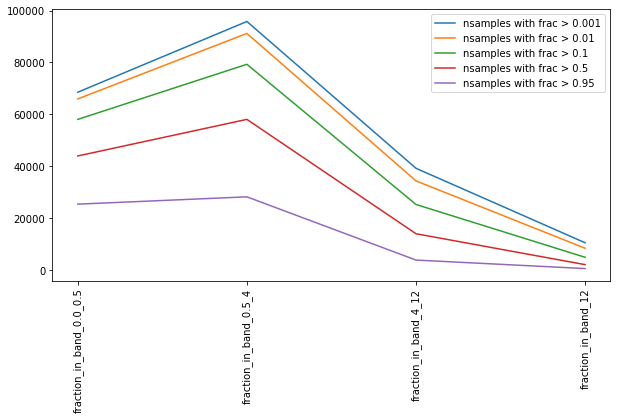

In [17]:
for frac in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(data_dims_dict['nbands']):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > frac))
    plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {frac}')
plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

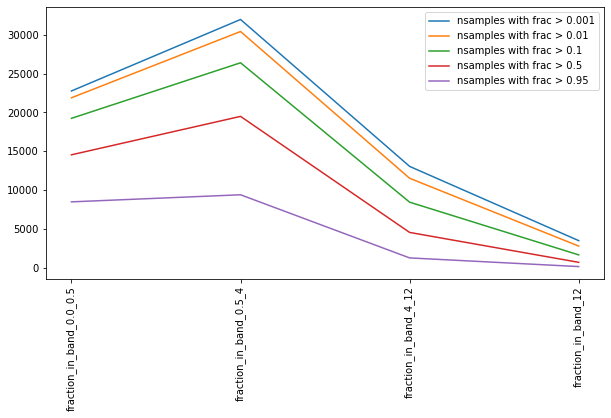

In [18]:
for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(data_dims_dict['nbands']):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

Resample data to create more uniform distribution within the training data

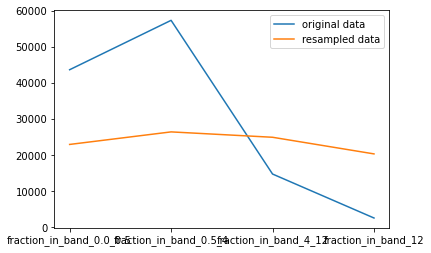

In [19]:
data_splits['y_train']['max_bin'] = data_splits['y_train'].idxmax(axis=1)

nsamples = len(data_splits['y_train'])//len(data_splits['y_train'].columns)

y_train = pd.DataFrame()

data_splits['y_train'] = data_splits['y_train'].reset_index(drop=True)
for col in data_splits['y_train'].columns[0:-1]:
    ids = data_splits['y_train'][data_splits['y_train']['max_bin']==col].index
    if len(ids)>0:
        choices = np.random.choice(ids, nsamples)
        y_train = pd.concat([y_train, data_splits['y_train'].loc[choices]])
        try: 
            X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
        except NameError:
            X_train = data_splits['X_train'][choices]

cols = data_splits['y_train'].columns[:-1]
plt.plot(data_splits['y_train'].sum(axis=0)[cols], label='original data')
plt.plot(y_train.sum(axis=0)[cols], label='resampled data')
plt.legend()
plt.show()

y_train = y_train.drop(columns=['max_bin'])

data_splits['X_train'] = X_train
data_splits['y_train'] = y_train
data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

## Set up model and experiment

In [20]:
def build_model(nprof_features, nheights, nsinglvl_features, nfractions=23):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(20, 5, strides=1, activation='relu')(out) #use_bias=False, bias_initializer='zeros'
    out = Dropout(0.8)(out)
    # ident = out
    # out = ZeroPadding1D(padding=1)(out)
    # out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, bias_initializer='zeros')(out)
    # out = ZeroPadding1D(padding=1)(out)
    # out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    # x = tf.keras.layers.add([out, ident])
    out = Flatten()(out)
    out = Dense(prof_size, activation='relu')(out) # use_bias=False,
    out = Dropout(0.5)(out)

#     if nsinglvl_features > 0:
#         surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
#         flat_profs = Flatten()(profile_input)
#         raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
#         raw_size = (nheights*nprof_features)+nsinglvl_features

#         out = tf.keras.layers.concatenate([out, surf_input])
#         x = tf.keras.layers.add([out, raw_in])
#         x = Dense(1024, use_bias=False, activation='relu')(x)
#         x = Dense(1024, use_bias=False, activation='relu')(x)

#         main_output = Dense(23, use_bias=True, activation='softmax', name='main_output')(x)
#         model = Model(inputs=[profile_input, surf_input], outputs=[main_output])

#     else:
    main_output = Dense(nfractions, activation='softmax', name='main_output')(out) # use_bias=True, 
    model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [21]:
def train_model(model, data_splits):
    # TODO: these hyperparameters should be read in from somewhere?
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer)
    model.compile(loss=tf.keras.losses.KLDivergence(), optimizer=optimizer, metrics=['accuracy'],)
    # model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], 
                        data_splits['y_train'], 
                        epochs=50, 
                        batch_size=100, 
                        validation_data=(data_splits['X_val'], data_splits['y_val']),  verbose=True)
    return model, history

In [22]:
# exp = mlflow.create_experiment('prd_frac_experiment')

In [23]:
exp1 = mlflow.get_experiment('2')
exp1

<Experiment: artifact_location='file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns/2', experiment_id='2', lifecycle_stage='active', name='prd_frac_experiment', tags={}>

In [24]:
with mlflow.start_run(experiment_id=exp1.experiment_id, run_name='new data - all members zeros included resampled') as current_run:
    model = build_model(data_dims_dict['nprof_features'], data_dims_dict['nheights'], data_dims_dict['nsinglvl_features'], data_dims_dict['nbands'])
    model.summary()
    model, history = train_model(model, data_splits)


2022-07-18 11:24:26.966649: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 profile_input (InputLayer)  [(None, 33, 2)]           0         
                                                                 
 zero_padding1d (ZeroPadding  (None, 35, 2)            0         
 1D)                                                             
                                                                 
 conv1d (Conv1D)             (None, 31, 20)            220       
                                                                 
 dropout (Dropout)           (None, 31, 20)            0         
                                                                 
 flatten (Flatten)           (None, 620)               0         
                                                                 
 dense (Dense)               (None, 66)                40986     
                                                             

2022-07-18 11:27:43.662953: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/tmp/tmpf6shuyq1/model/data/model/assets


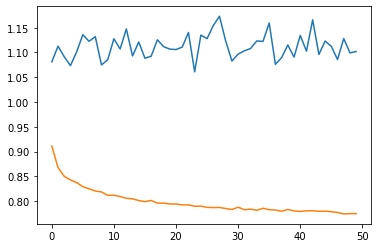

In [25]:
plt.plot(range(50), history.history['val_loss'])
plt.plot(range(50), history.history['loss'])

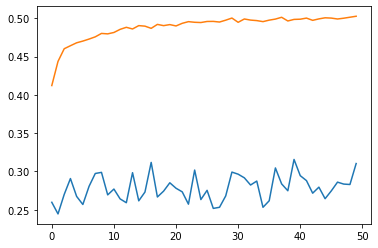

In [26]:
plt.plot(range(50), history.history['val_accuracy'])
plt.plot(range(50), history.history['accuracy'])

In [27]:
y_pred = model.predict(data_splits['X_val'])
# error = mean_absolute_error(data_splits['y_val'], y_pred)
# print(f'MAE: {error:.3f}')
# rsqrd = r2_score(data_splits['y_val'],, y_pred)
# print(f'R-squared score: {rsqrd:.3f}')


# fig1 = plt.figure(figsize=(10, 8))
# ax1 = fig1.add_subplot(1,1,1, title='Actual vs #predicted 3hr rainfall accumulations.')
# ax1.scatter(y_test, y_pred, s=200, c='darkblue')
# ax1.plot([0, 300], [0, 300], ls="--", c=".3")
# ax1.set_xlabel('Actual 3hr precip accumulation value')
# ax1.set_ylabel('Predicted 3hr precip_accumulation value')

# fig1 = plt.figure(figsize=(10, 8))
# ax1 = fig1.add_subplot(1,1,1, title='Historgram of Actual vs predicted 3hr rainfall accumulations.')
# ax1.hist(y_test, alpha=0.5, bins=40, label='Actual')
# ax1.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
# ax1.legend()  

In [28]:
# plt.plot(y_pred[0] - data_splits['y_val'].iloc[0])

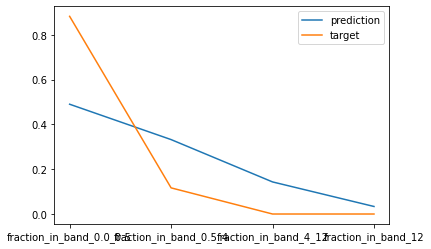

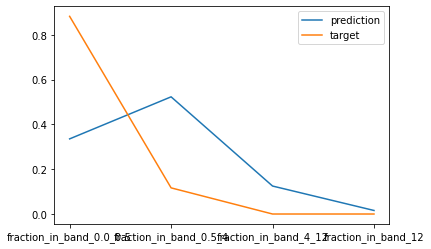

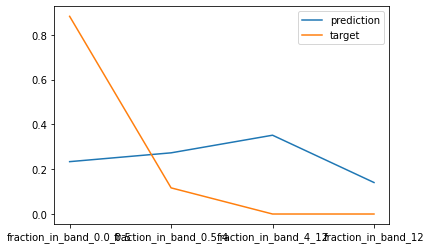

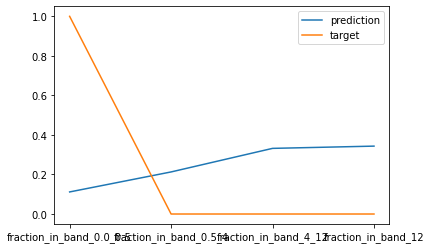

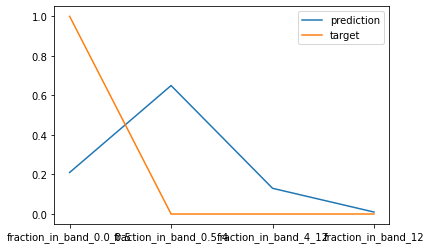

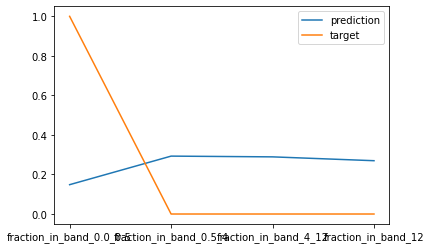

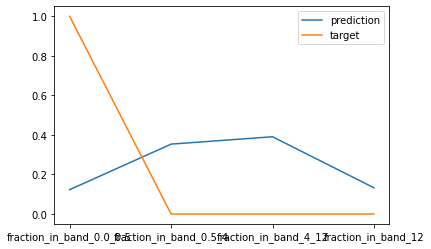

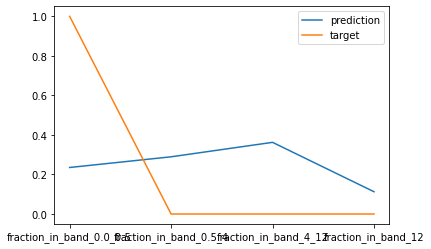

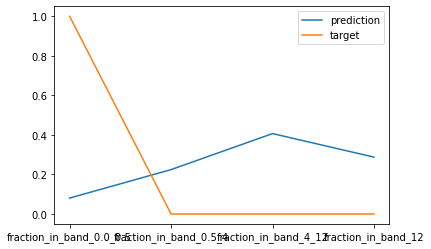

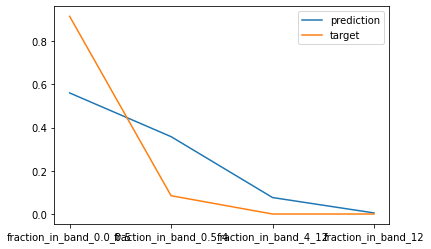

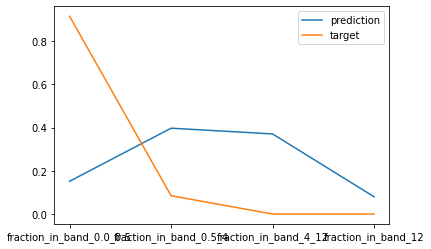

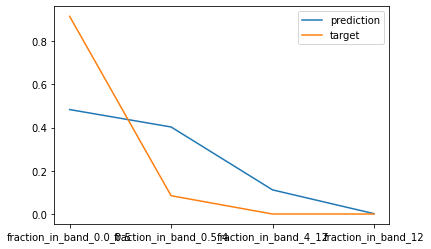

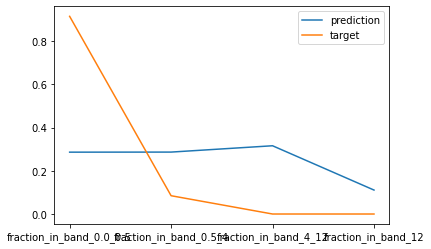

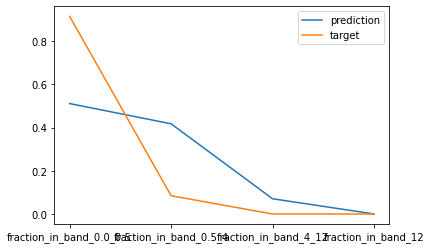

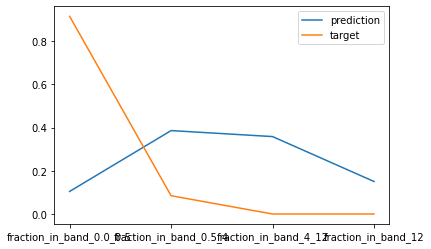

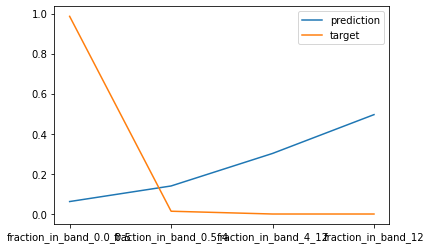

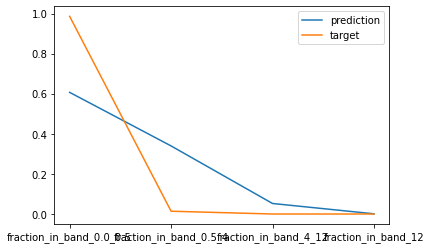

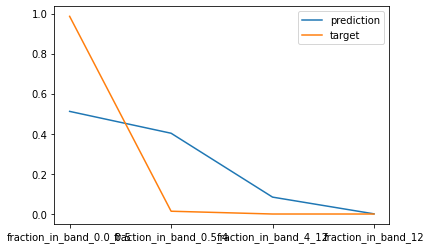

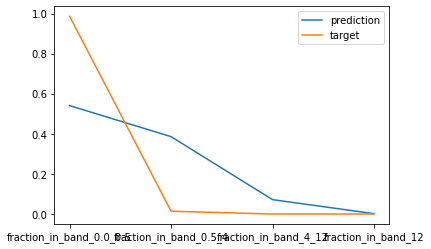

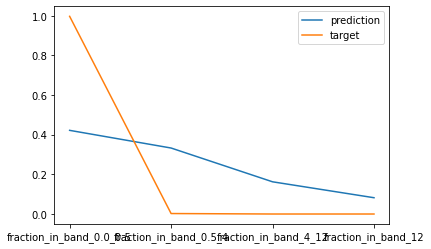

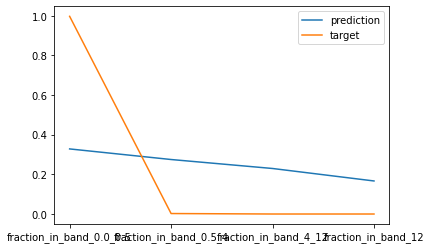

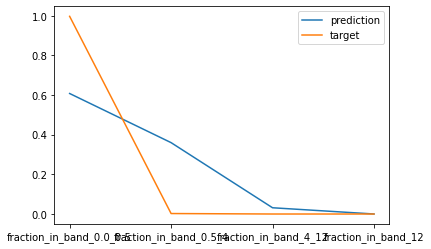

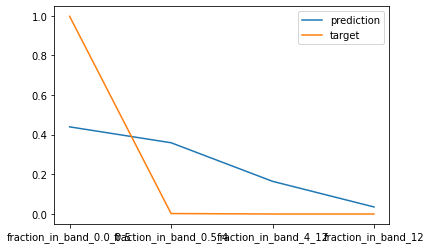

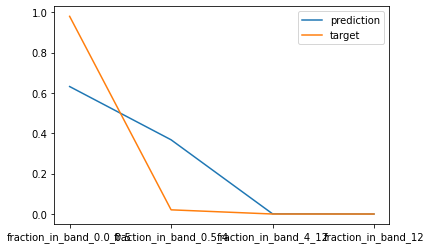

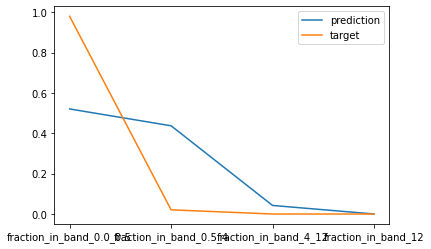

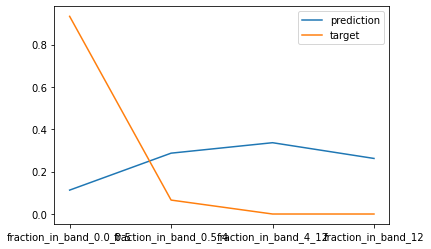

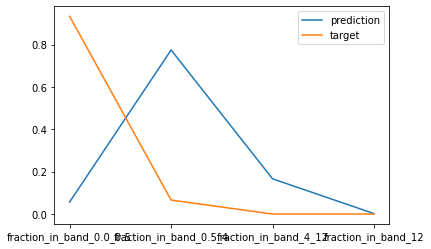

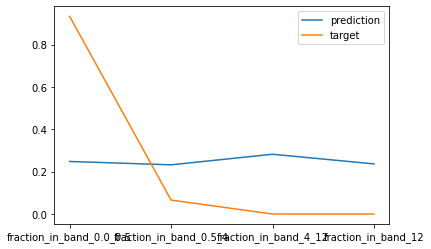

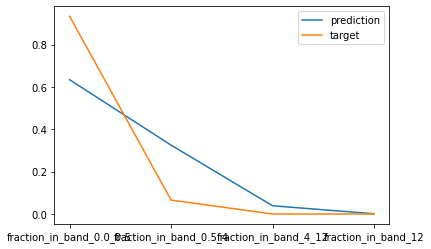

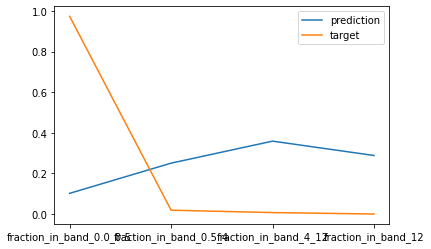

In [29]:
for loc in range(30):
    plt.plot(y_pred[loc], label='prediction')
    plt.plot(data_splits['y_val'].iloc[loc], label='target')
    plt.legend()
    plt.show()

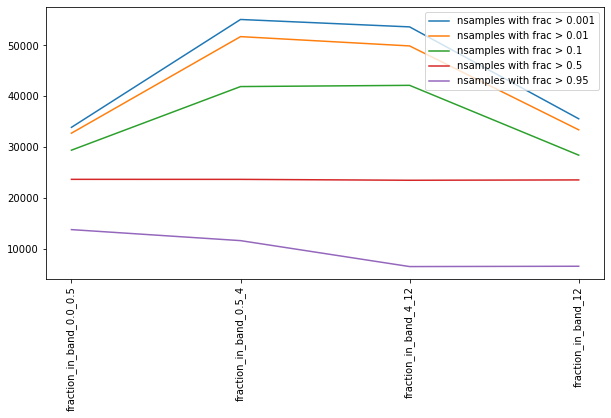

In [30]:
for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

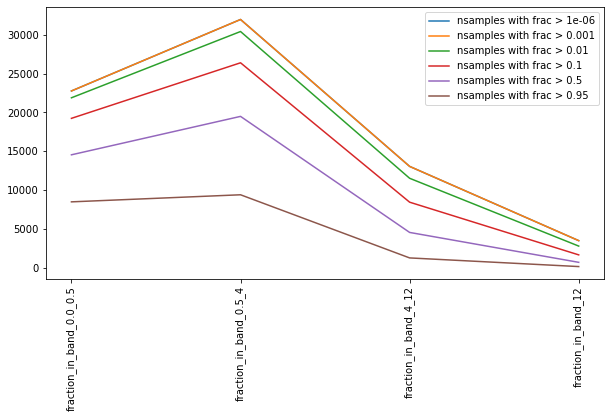

In [31]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

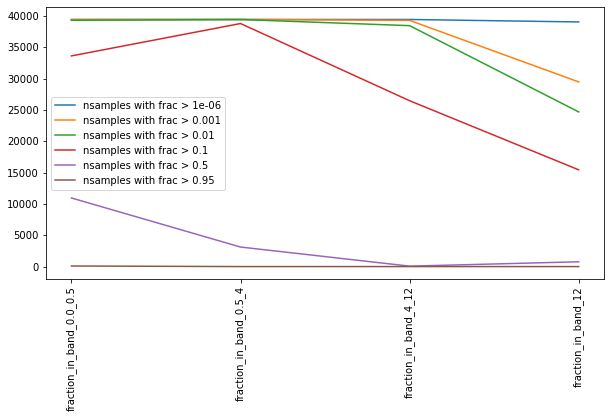

In [32]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(y_pred[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [33]:
# for prob in [ 0.001, 0.01, 0.1, 0.5, 0.75, 0.95]:
#     exceeding_prob_val = []
#     exceeding_prob_pred = []
#     for thresh in range(23):
#         exceeding_prob_val.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
#         exceeding_prob_pred.append(sum(y_pred[:, thresh] > prob))
#     plt.plot(np.arange(23), exceeding_prob_val, label=f'actual vals')
#     plt.plot(np.arange(23), exceeding_prob_pred, label=f'predicted vals')
#     plt.title(f'nsamples with frac > {prob}')
#     plt.xticks(np.arange(23), data_splits['y_train'].columns, rotation=90)
#     plt.legend()
#     plt.gcf().set_size_inches(10, 5)
#     plt.show()

In [34]:
data_splits['y_train'].iloc[:, thresh]

112069    0.000000
8475      0.000000
12049     0.000000
87551     0.000000
11588     0.000000
            ...   
26430     0.978622
29200     0.670792
29941     0.919395
93514     1.000000
26759     1.000000
Name: fraction_in_band_12, Length: 94668, dtype: float64

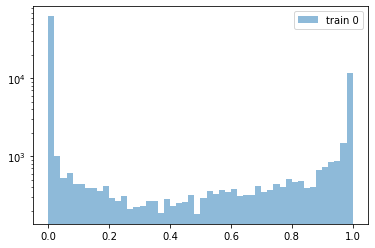

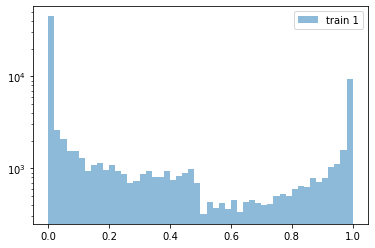

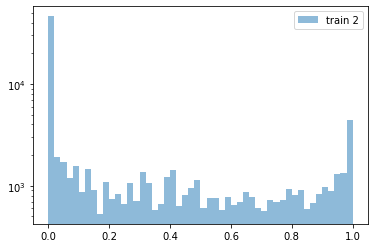

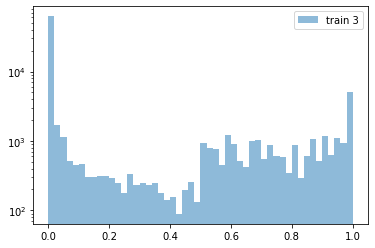

In [35]:
for thresh in range(4): 
    bins=np.linspace(0,1,51)
    # plt.hist(y_pred[:, thresh], alpha=0.5, label='pred', bins=bins, log=True)#,stacked=True, density=True
    # plt.hist(data_splits['y_val'].iloc[:, thresh], alpha=0.5, label=f'val {thresh}', bins=bins,log=True, ) # stacked=True, density=True
    plt.hist(data_splits['y_train'].iloc[:, thresh], alpha=0.5, label=f'train {thresh}', bins=bins, log=True)#  stacked=True, density=True
    plt.legend()
    plt.show()

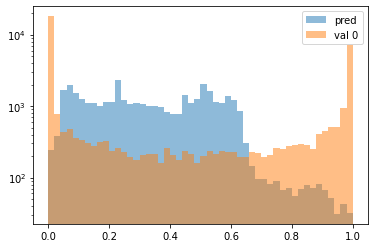

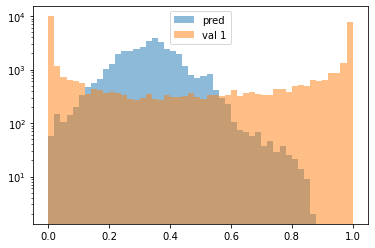

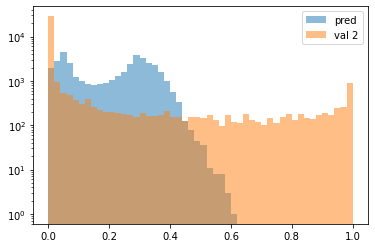

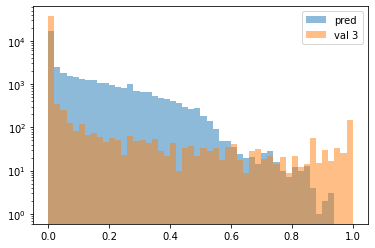

In [36]:
for thresh in range(4): 
    bins=np.linspace(0,1,51)
    plt.hist(y_pred[:, thresh], alpha=0.5, label='pred', bins=bins, log=True)#,stacked=True, density=True
    plt.hist(data_splits['y_val'].iloc[:, thresh], alpha=0.5, label=f'val {thresh}', bins=bins,log=True, ) # stacked=True, density=True
    # plt.hist(data_splits['y_train'].iloc[:, thresh], alpha=0.5, label=f'train {thresh}', bins=bins, histtype='step', log=True)#  stacked=True, density=True
    plt.legend()
    plt.show()
    
#     error = mean_absolute_error(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'MAE: {error:.3f}')
#     rsqrd = r2_score(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'R-squared score: {rsqrd:.3f}')
    